In [1]:
import torch
from torch.utils.data import DataLoader
from dynamic_model.dataset import load_dataset
from dynamic_model.dataset import DynamicsModelDataset
from dynamic_model.model import DynamicsLookAheadModel, ConstLookAheadModel
from dynamic_model.train import train_model, test_step
from dynamic_model.eval import eval_model, compare_models

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(f"Using Device: {device}")
torch.backends.cudnn.benchmark = True


Using Device: cuda:0


## Load Dataset

In [5]:
dataset_input_key = 'merged_input'
dataset_output_key = 'merged_output'
dataset_file_path = 'tmp/ib-out/ib-samples-la.npy'
normalized_data_params_save_path = 'dynamic_model/NormalizeInputConfigs.pkl'
dataset_device = 'cpu'
y_indexes = [4, 6]

train_dataset, val_dataset = load_dataset(file_path=dataset_file_path, input_key=dataset_input_key,
                                          output_key=dataset_output_key, dataset_class=DynamicsModelDataset,
                                          normalize=True, device=dataset_device, y_clip_range=y_indexes,
                                          normalized_data_params_save_path=normalized_data_params_save_path)

batch_size = 8000
params = {'batch_size': batch_size,
          'shuffle': True,
          'num_workers': 0,
          'drop_last': True,
          'pin_memory': not train_dataset.x.is_cuda}
print(params)
train_loader = DataLoader(train_dataset, **params)
val_loader = DataLoader(val_dataset, **params)
train_dataset.y[0]

Clipping y
torch.Size([672000, 39, 6])
torch.Size([672000, 10, 2])
torch.Size([288000, 39, 6])
torch.Size([288000, 10, 2])
{'batch_size': 8000, 'shuffle': True, 'num_workers': 0, 'drop_last': True, 'pin_memory': True}


tensor([[-0.3383,  0.0360],
        [ 0.0816,  0.0208],
        [-0.4579, -0.0349],
        [-0.5403, -0.1355],
        [-0.3761, -0.1720],
        [-0.2983, -0.2066],
        [ 0.0108, -0.2211],
        [-0.4697, -0.2758],
        [-0.5826, -0.2571],
        [-0.4972, -0.2432]])

## Define model

In [4]:
model_dict_path = 'dynamic_model/model_dict'
model_path = 'dynamic_model/model'
num_of_features = train_dataset.get_features_size()
seq_len = train_dataset.get_seq_len()
hidden_size = 16
out_size = train_dataset.get_output_feature_size()
print(f'Out Size:{out_size}')
look_ahead = train_dataset.get_look_ahead_size()
n_layers = 2
dropout_p = 0.2
print(look_ahead)
model = DynamicsLookAheadModel(features=num_of_features, hidden_size=hidden_size, out_size=out_size, seq_len=seq_len,
                               n_layers=n_layers, dropout_p=dropout_p,
                               look_ahead=look_ahead).to(device=device)

load_to_gpu = model.is_cuda() and not train_dataset.x.is_cuda
print(load_to_gpu)

Out Size:2
9
True


## Train Model

In [5]:
train_model(model=model, train_loader=train_loader, test_loader=val_loader, n_epochs=100, learning_rate=1e-3,
            load_to_gpu=load_to_gpu, gamma=0.1, lr_milestones=[60])

Untrained test
--------
Actual: tensor([-1.0641,  1.9653], device='cuda:0')
Predicted: tensor([ 0.2496, -0.1642], device='cuda:0')
Test loss: 1.0442038625478745

Epoch 0
---------
Train loss: 0.8392903833162217
Actual: tensor([ 0.8055, -0.6969], device='cuda:0')
Predicted: tensor([ 0.8764, -0.5691], device='cuda:0')
Test loss: 0.5509546912378736
lr: [0.001]
Epoch time: epoch_time = 7.723s
Epoch 1
---------
Train loss: 0.35740876552604495
Actual: tensor([-0.7101, -0.3961], device='cuda:0')
Predicted: tensor([-0.2320, -0.1973], device='cuda:0')
Test loss: 0.19319939158029026
lr: [0.001]
Epoch time: epoch_time = 7.664s
Epoch 2
---------
Train loss: 0.16130804447900682
Actual: tensor([ 2.4130, -0.7250], device='cuda:0')
Predicted: tensor([ 3.4365, -0.8975], device='cuda:0')
Test loss: 0.12701001287334496
lr: [0.001]
Epoch time: epoch_time = 7.781s
Epoch 3
---------
Train loss: 0.12238635752527487
Actual: tensor([-0.9125,  5.3570], device='cuda:0')
Predicted: tensor([-1.0124,  5.3804], devi

## Save Model

In [6]:

torch.save(model.state_dict(), model_dict_path)
torch.save(model, model_path)
torch.cuda.empty_cache()
del model

## Load Model for evaluation

In [7]:

model_classes = [DynamicsLookAheadModel, ConstLookAheadModel]
models = []
for model_class in model_classes:
    models.append(model_class(features=num_of_features, hidden_size=hidden_size, out_size=out_size,
                              seq_len=seq_len, n_layers=n_layers, dropout_p=dropout_p,
                              look_ahead=look_ahead).to(device))
    models[-1].load_state_dict(torch.load(model_dict_path))

In [8]:
for la_model in models:
    print(la_model.__class__.__name__)
    test_step(model=la_model, data_loader=val_loader, loss_function=torch.nn.MSELoss(), load_to_gpu=load_to_gpu)

DynamicsLookAheadModel
Actual: tensor([-0.2577, -0.2385], device='cuda:0')
Predicted: tensor([-0.4777, -0.1652], device='cuda:0')
Test loss: 0.05104244086477491
ConstLookAheadModel
Actual: tensor([ 0.6169, -0.5858], device='cuda:0')
Predicted: tensor([ 0.8308, -0.5802], device='cuda:0')
Test loss: 0.14372116906775367


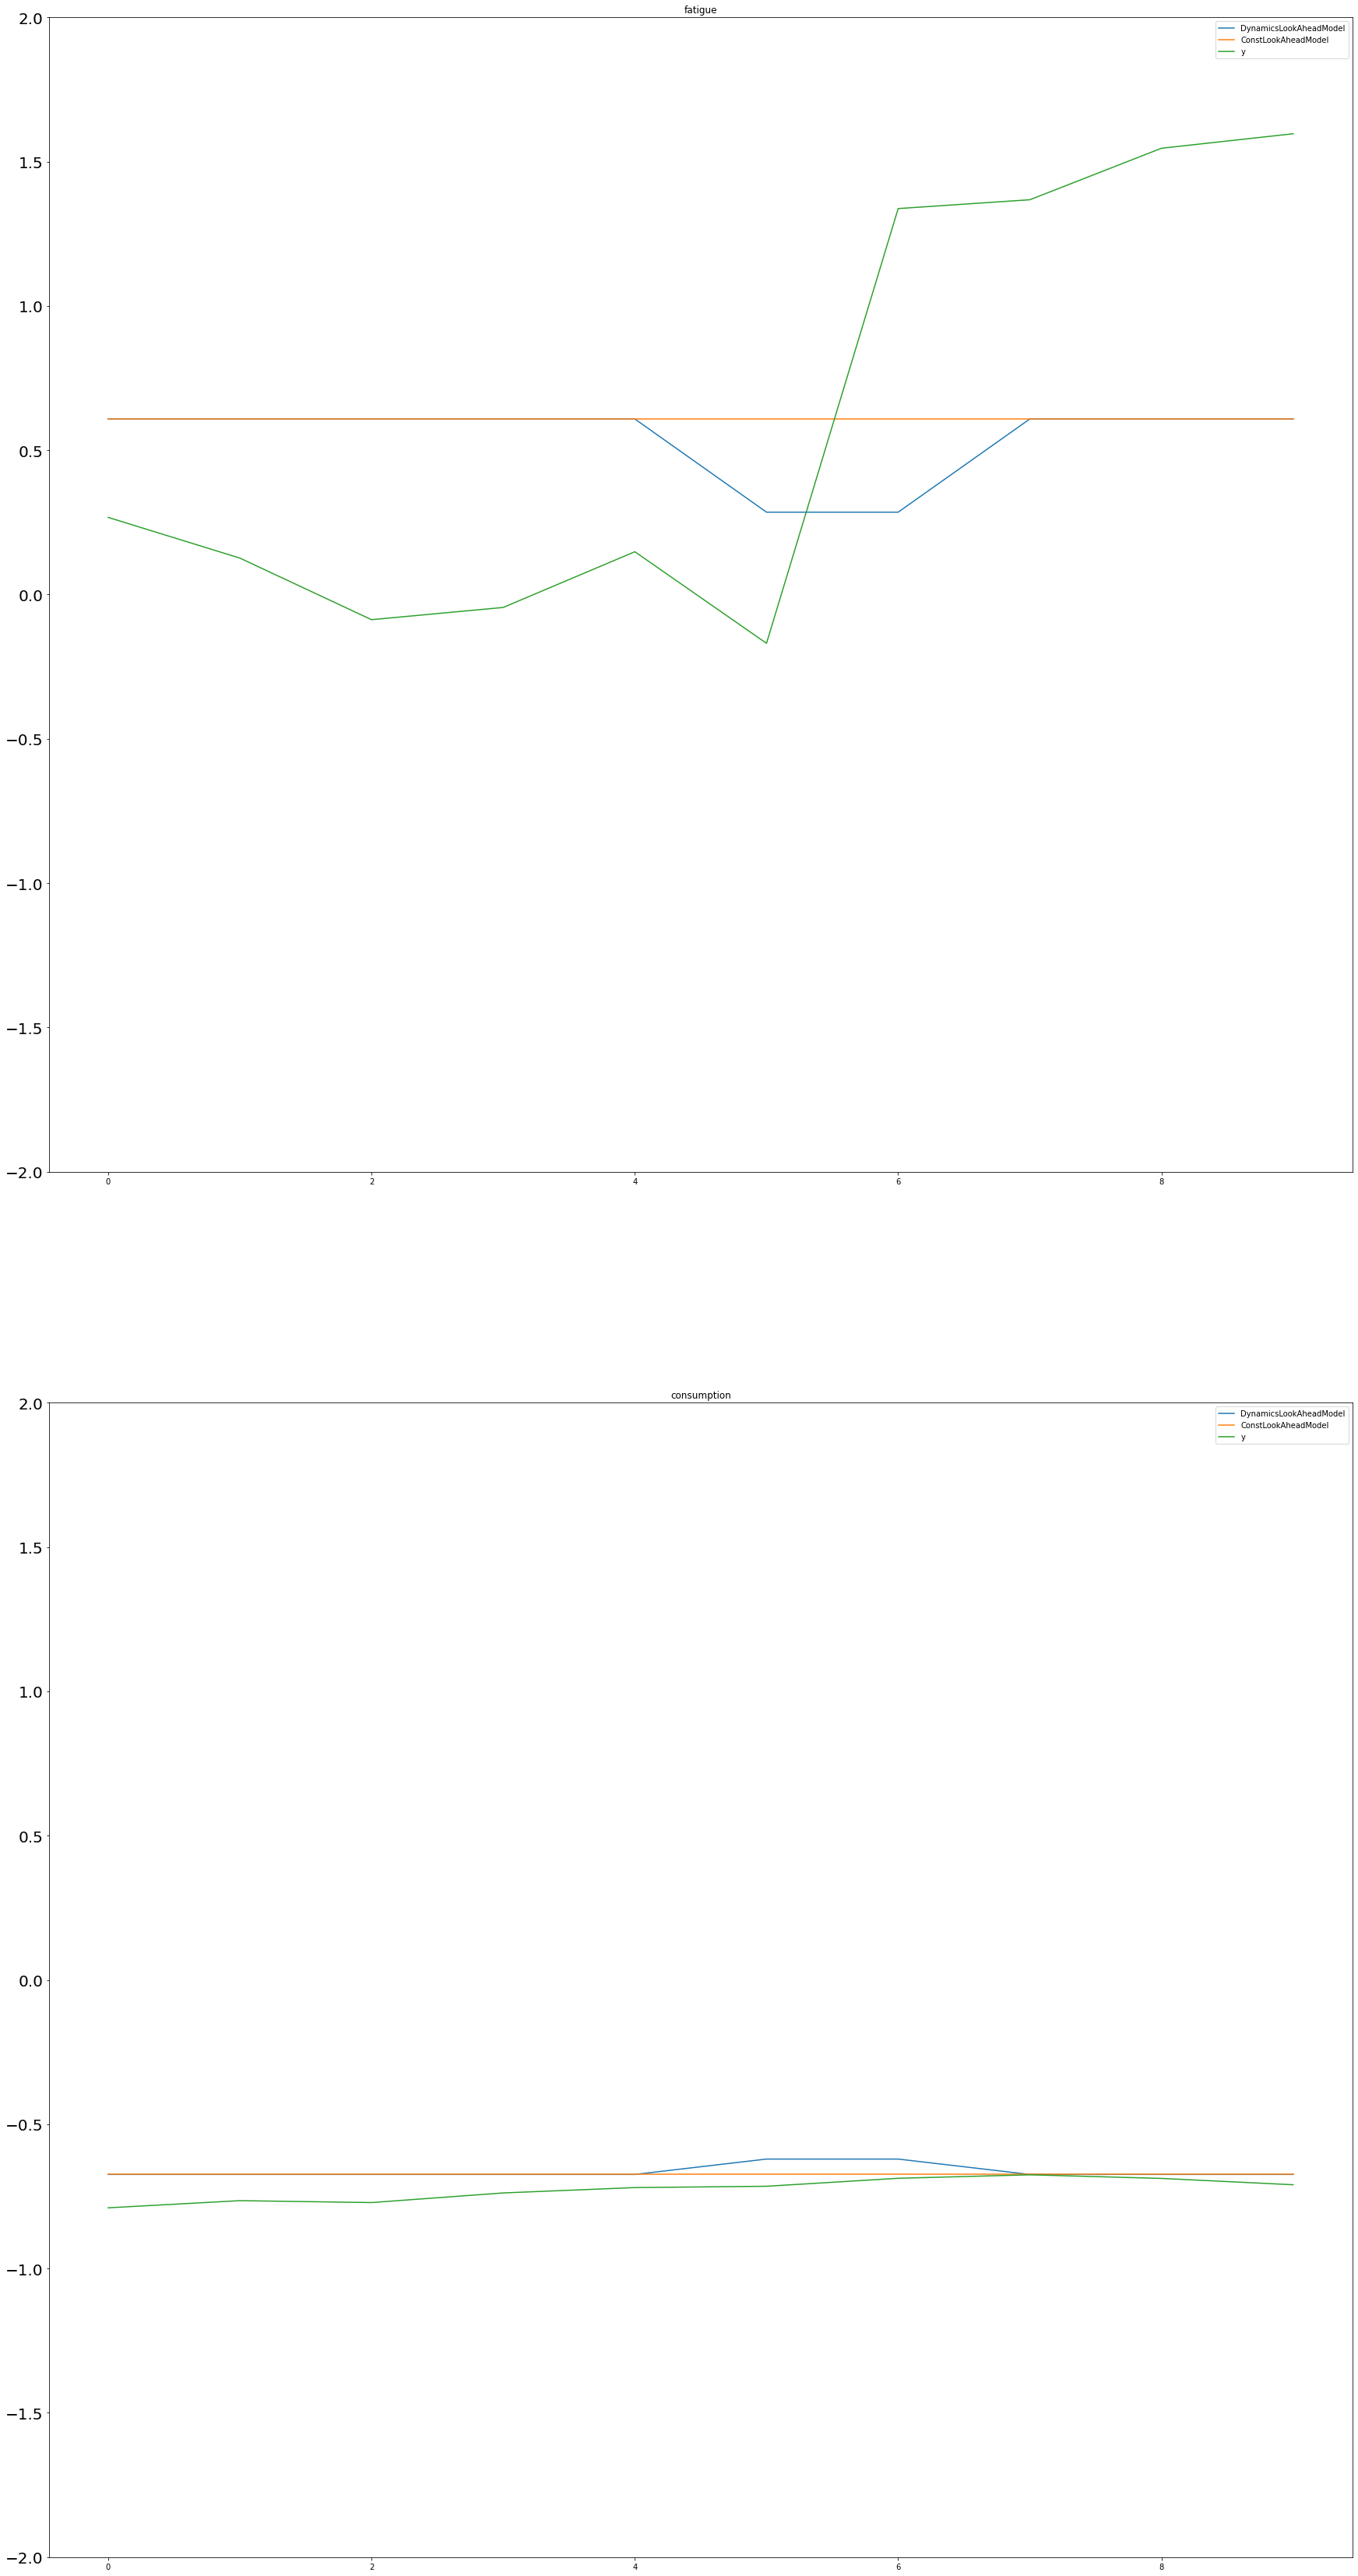

In [9]:
#value_keys = ['setpoint', 'velocity', 'gain', 'shift', 'fatigue', 'consumption']
value_keys = ['fatigue', 'consumption']

models = []
for model_class in model_classes:
    models.append(model_class(features=num_of_features, hidden_size=hidden_size, out_size=out_size,
                              seq_len=seq_len, n_layers=n_layers, dropout_p=dropout_p,
                              look_ahead=look_ahead).to(dataset_device))
    models[-1].load_state_dict(torch.load(model_dict_path))

compare_models(models, x=val_dataset.x[78], y=val_dataset.y[78], value_keys=value_keys)